In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

# training set
Our training set is a simple Gaussian distribution

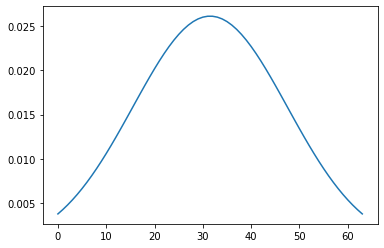

In [2]:
def gaussian_pdf(num_bit, mu, sigma):
    '''get gaussian distribution function'''
    x = np.arange(4**num_bit)     # changed 2 to 4
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()

num_bit = 3
pg = gaussian_pdf(num_bit, mu=2**(2*num_bit-1)-0.5, sigma=2**4)  # was 2**4
plt.plot(pg)
plt.show()

# Build Circuits
## Building Blocks
Define matrix representations of operations using scipy sparse matrices.
They are grouped to become a layer in a circuit, this layer can be `ArbitraryRotation` or `CNOTEntangler`.
Which are used as our basic building blocks of our `Born Machines`.

In [0]:
######  Pauli Matrices  ########
I2 = sps.eye(2).tocsr()
sx = sps.csr_matrix([[0,1],[1,0.]])
sy = sps.csr_matrix([[0,-1j],[1j,0.]])
sz = sps.csr_matrix([[1,0],[0,-1.]])

p0 = (sz + I2) / 2   #projection operator to |0><0|
p1 = (-sz + I2) / 2

# single bit rotation matrices
def _ri(si, theta):
    return np.cos(theta/2.)*I2 - 1j*np.sin(theta/2.)*si

def rot(t1, t2, t3):
    '''
    a general rotation gate rz(t3)rx(r2)rz(t1).

    Args:
        t1, t2, t3 (float): three angles.

    Returns:
        2x2 csr_matrix: rotation matrix.
    '''
    return _ri(sz, t3).dot(_ri(sx, t2)).dot(_ri(sz, t1))

# multiple bit construction
def CNOT(ibit, jbit, n):
    '''
    CNOT gate
    
    Args:
        ibit (int): control bit.
        jbit (int): controled bit.
        n (int): total number of qubits.
        
    Returns:
        4x4 csr_matrix: CNOT matrix.
    '''
    res = _([p0, I2], [ibit, jbit], n)
    res = res + _([p1, sx], [ibit, jbit], n)
    return res

def _(ops, locs, n):
    '''
    Compile operators into specific Hilbert space.

    notice the last bit is the high end bit!

    Args:
        ops (list): list of single bit operators.
        locs (list): list of positions.
        n (int): total number of bits.

    Returns:
        csr_matrix: resulting matrix.
    '''
    if np.ndim(locs) == 0:
        locs = [locs]
    if not isinstance(ops, (list, tuple)):
        ops = [ops]
    locs = np.asarray(locs)
    locs = n - locs
    order = np.argsort(locs)
    locs = np.concatenate([[0], locs[order], [n + 1]])
    return _wrap_identity([ops[i] for i in order], np.diff(locs) - 1)


def _wrap_identity(data_list, num_bit_list):
    if len(num_bit_list) != len(data_list) + 1:
        raise Exception()

    res = sps.eye(2**num_bit_list[0])
    for data, nbit in zip(data_list, num_bit_list[1:]):
        res = sps.kron(res, data)
        res = sps.kron(res, sps.eye(2**nbit, dtype='complex128'))
    return res


def initial_wf(num_bit):
    '''initial wave function |00...0>.'''
    wf = np.zeros(2**num_bit, dtype='complex128')
    wf[0] = 1.
    return wf

In [0]:
class ArbitraryRotation(object):
    '''Arbitrary rotation gate'''
    def __init__(self, num_bit):
        self.num_bit = num_bit
        # mask is used to filter out some irrelevant (marked False) parameters
        self.mask = np.array([True] * (3*num_bit), dtype='bool')

    @property
    def num_param(self):
        return self.mask.sum()

    def tocsr(self, theta_list):
        '''transform this block to a sequence of csr_matrices.'''
        theta_list_ = np.zeros(3*self.num_bit)
        theta_list_[self.mask] = theta_list
        rots = [rot(*ths) for ths in theta_list_.reshape([self.num_bit,3])]
        res = [_([r], [i], self.num_bit) for i,r in enumerate(rots)]
        return res

class CNOTEntangler(object):
    '''
    CNOT Entangler Layer.
    
    Args:
        pairs (list): a list of tuples to represent connections.
    '''
    def __init__(self, num_bit, pairs):
        self.num_bit = num_bit
        self.pairs = pairs

    @property
    def num_param(self):
        return 0

    def tocsr(self, theta_list):
        '''transform this block to a sequence of csr_matrices.'''
        i, j = self.pairs[0]
        res = CNOT(i, j, self.num_bit)
        for i, j in self.pairs[1:]:
            res = CNOT(i,j,self.num_bit).dot(res)
        res.eliminate_zeros()
        return [res]

# Circuit
A circuit is consist of queued layers, here this data structure is `BlockQueue`. A `BlockQueue` uses `theta_last` and `memo` attributes to cache sparse operators, this will accelerate simulation significantly.

In [0]:
class BlockQueue(list):
    '''
    Block Queue that keep track of theta_list changing history, for fast update.
    
    Attributes:
        theta_last (1darray): the cached circuit parameters.
        memo (list): cached sparse matrices for layers.
    '''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.theta_last = None
        self.memo = None

    def __call__(self, qureg, theta_list):
        '''
        Apply operations on vector basis: qureg. This operation changes vector inplace.
        
        Args:
            qureg (1darray): vector basis.
            theta_list (1darray): circuit parameters:
        '''
        # cache? if theta_list change <= 1 parameters, then don't touch memory.
        remember = self.theta_last is None or (abs(self.theta_last-theta_list)>1e-12).sum() > 1

        mats = []
        theta_last = self.theta_last
        if remember:
            self.theta_last = theta_list.copy()

        qureg_ = qureg
        for iblock, block in enumerate(self):
            # generate or use a block matrix
            num_param = block.num_param
            theta_i, theta_list = np.split(theta_list, [num_param])
            if theta_last is not None:
                theta_o, theta_last = np.split(theta_last, [num_param])
            if self.memo is not None and (num_param==0 or np.abs(theta_i-theta_o).max()<1e-12):
                # use data cached in memory
                mat = self.memo[iblock]
            else:
                if self.memo is not None and not remember:
                    # update the changed gate, but not touching memory.
                    mat = _rot_tocsr_update1(block, self.memo[iblock], theta_o, theta_i)
                else:
                    # regenerate one
                    mat = block.tocsr(theta_i)
            for mat_i in mat:
                qureg_ = mat_i.dot(qureg_)
            mats.append(mat)

        if remember:
            # cache data
            self.memo = mats
        # update register
        qureg[...] = qureg_
        np.testing.assert_(len(theta_list)==0)
        
    @property
    def num_bit(self):
        return self[0].num_bit

    @property
    def num_param(self):
        return sum([b.num_param for b in self])

def _rot_tocsr_update1(layer, old, theta_old, theta_new):
    '''
    rotation layer csr_matrices update method.
    
    Args:
        layer (ArbitraryRotation): rotation layer.
        old (csr_matrix): old matrices.
        theta_old (1darray): old parameters.
        theta_new (1darray): new parameters.

    Returns:
        list of csr_matrix: new rotation matrices after the theta changed.
    '''
    idiff_param = np.where(abs(theta_old-theta_new)>1e-12)[0].item()
    idiff = np.where(layer.mask)[0][idiff_param]

    # get rotation parameters
    isite = idiff//3
    theta_list_ = np.zeros(3*layer.num_bit)
    theta_list_[layer.mask] = theta_new
    
    new = old[:]
    new[isite] = _(rot(*theta_list_[isite*3:isite*3+3]), isite, layer.num_bit)
    return new

In [0]:
def get_nn_pairs(num_bit):
    '''get nearest neighbor pairs.'''
    res = []
    for inth in range(2):
        for i in range(inth, num_bit, 2):
            res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
    return res

def get_demo_circuit(num_bit, depth, pairs):
    '''Get the circuit used for demo'''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))

    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [7]:
# let's see how this circuit look like
depth = 6
pairs = get_nn_pairs(num_bit)
circuit = get_demo_circuit(num_bit, depth, pairs)
print(circuit)

[<__main__.ArbitraryRotation object at 0x7f90759e75f8>, <__main__.CNOTEntangler object at 0x7f90759e7f98>, <__main__.ArbitraryRotation object at 0x7f90759e7be0>, <__main__.CNOTEntangler object at 0x7f90759e79e8>, <__main__.ArbitraryRotation object at 0x7f90759e77b8>, <__main__.CNOTEntangler object at 0x7f90759e7ba8>, <__main__.ArbitraryRotation object at 0x7f90749cb048>, <__main__.CNOTEntangler object at 0x7f90749cb358>, <__main__.ArbitraryRotation object at 0x7f90749cb3c8>, <__main__.CNOTEntangler object at 0x7f90749cb080>, <__main__.ArbitraryRotation object at 0x7f90749cb128>, <__main__.CNOTEntangler object at 0x7f90749cb438>, <__main__.ArbitraryRotation object at 0x7f90749cb1d0>]


In [8]:
# let's see how this circuit works
# rotating the last bit along x axis by pi/2.
theta_list = np.zeros(circuit.num_param)
print(theta_list)
theta_list[-1] = np.pi/2

wf = initial_wf(num_bit)
circuit(wf, theta_list)

# now you see the last bit is the high end bit!
print(wf)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.70710678+0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        -0.70710678j 0.        +0.j
 0.        +0.j         0.        +0.j        ]


# MMD Loss Function
As a reminder
\begin{align}
    \mathcal{L} =&  \left\|\sum_{x} p_\theta(x) \phi(x)- \sum_{x} \pi(x) \phi(x)  \right\|^2 \\
    =&\langle K(x,y)\rangle_{x\sim p_\theta, y\sim p_\theta}-2\langle K(x,y)\rangle_{x\sim p_\theta,y\sim \pi}+\langle K(x, y)\rangle_{x\sim \pi,y\sim \pi}
\end{align}


In [0]:
class RBFMMD2(object):
    '''
    MMD^2 with RBF (Gaussian) kernel.
    
    Args:
        sigma_list (list): a list of bandwidths.
        basis (1darray): defininng space.
      
    Attributes:
        K (2darray): full kernel matrix, notice the Hilbert is countable.
    '''
    def __init__(self, sigma_list, basis):
        self.sigma_list = sigma_list
        self.basis = basis
        self.K = mix_rbf_kernel(basis, basis, self.sigma_list)

    def __call__(self, px, py):
        '''
        Args:
            px (1darray, default=None): probability for data set x, used only when self.is_exact==True.
            py (1darray, default=None): same as px, but for data set y.

        Returns:
            float: loss.
        '''
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        '''
        expectation value of kernel function.
        
        Args:
            px (1darray): the first PDF.
            py (1darray): the second PDF.
            
        Returns:
            float: kernel expectation.
        '''
        return px.dot(self.K).dot(py)

def mix_rbf_kernel(x, y, sigma_list):
    '''
    multi-RBF kernel.
    
    Args:
        x (1darray|2darray): the collection of samples A.
        x (1darray|2darray): the collection of samples B.
        sigma_list (list): a list of bandwidths.
        
    Returns:
        2darray: kernel matrix.
    '''
    ndim = x.ndim
    if ndim == 1:
        exponent = np.abs(x[:, None] - y[None, :])**2
    elif ndim == 2:
        exponent = ((x[:, None, :] - y[None, :, :])**2).sum(axis=2)
    else:
        raise
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

In [10]:
hndim = 2**num_bit
# mmd loss
mmd = RBFMMD2(sigma_list=[0.25,4], basis=np.arange(4**num_bit))   # changed to 4

# when exact match, MMD loss should be 0, e.g. two gaussians
print('Exact Match -> MMD = %.4f'%mmd(pg, pg))
# when not match, loss is not zero
prand = np.random.random(len(pg))
print('Not Match -> MMD = %.4f'%mmd(prand/prand.sum(), pg))

Exact Match -> MMD = 0.0000
Not Match -> MMD = 0.0381





# 4-Pauli POVMs
The 4-Pauli POVMs for a single qubit are given by
\begin{align}
M^{(0)} &= \frac{1}{3}|0\rangle\langle0| \\
M^{(1)} &= \frac{1}{3}|+\rangle\langle+| \\
M^{(2)} &= \frac{1}{3}|r\rangle\langle r| \\
M^{(3)} &= \textbf{1} - M^{(0)} - M^{(1)} - M^{(2)}
\end{align}




In [11]:
# Eigenvectors
up = np.array([1+0j,0+0j], dtype='complex128')
plus = np.array([1+0j,1+0j], dtype='complex128') / np.sqrt(2)
right = np.array([1+0j,0+1j], dtype='complex128') / np.sqrt(2)

print(up)
print(plus)
print(right)

[1.+0.j 0.+0.j]
[0.70710678+0.j 0.70710678+0.j]
[0.70710678+0.j         0.        +0.70710678j]


In [0]:
I = np.array([[1,0],[0,1]], dtype='complex128')
X = np.array([[0, 1],[1, 0]], dtype='complex128')
Z = np.array([[1, 0],[0, -1]], dtype='complex128')
Y = np.array([[0, -1j],[1j, 0]], dtype='complex128')

In [13]:
v1 = np.array([0, 0, 1])
M0 = (I + v1[0]*X + v1[1]*Y + v1[2]*Z)/4
v2 = np.array([2*np.sqrt(2)/3, 0, -1/3])
M1 = (I + v2[0]*X + v2[1]*Y + v2[2]*Z)/4
v3 = np.array([-np.sqrt(2)/3, np.sqrt(2)/3, -1/3])
M2 = (I + v3[0]*X + v3[1]*Y + v3[2]*Z)/4
v4 = np.array([-np.sqrt(2)/3, -np.sqrt(2)/3, -1/3])
M3 = (I + v4[0]*X + v4[1]*Y + v4[2]*Z)/4
M0+M1+M2+M3

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [14]:
# # 4-Pauli POVMs for a single qubit
# M0 = np.outer(up, np.conj(up)) / 3
# M1 = np.outer(plus, np.conj(plus)) / 3
# M2 = np.outer(right, np.conj(right)) / 3
# M3 = np.eye(2, dtype='complex128') - M0 - M1 - M2

print(M0)
print(M1)
print(M2)
print(M3)

[[0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j]]
[[0.16666667+0.j 0.23570226+0.j]
 [0.23570226+0.j 0.33333333+0.j]]
[[ 0.16666667+0.j         -0.11785113-0.11785113j]
 [-0.11785113+0.11785113j  0.33333333+0.j        ]]
[[ 0.16666667+0.j         -0.11785113+0.11785113j]
 [-0.11785113-0.11785113j  0.33333333+0.j        ]]


In [0]:
# make tensor product of POVMs
def tensorproduct(matrix1, matrix2):
    dim = matrix1.shape[0] * matrix2.shape[0]
    
    # has to reverse the order otherwise doesn't work
    return np.tensordot(matrix2, matrix1, axes = 0).swapaxes(1, 2).reshape(dim, dim)

In [16]:
# proof of concept
Ms = ['M0', 'M1', 'M2', 'M3'] # POVMs
Mlist = Ms[:] # make a copy

for i in range(num_bit - 1):  # minus one because we initialized above
    Mlisttemp = []
    for m2 in Mlist:
        for m1 in Ms:
            Mlisttemp.append(m1 + ' dot ' + m2)
    Mlist = Mlisttemp
print(Mlist)

['M0 dot M0 dot M0', 'M1 dot M0 dot M0', 'M2 dot M0 dot M0', 'M3 dot M0 dot M0', 'M0 dot M1 dot M0', 'M1 dot M1 dot M0', 'M2 dot M1 dot M0', 'M3 dot M1 dot M0', 'M0 dot M2 dot M0', 'M1 dot M2 dot M0', 'M2 dot M2 dot M0', 'M3 dot M2 dot M0', 'M0 dot M3 dot M0', 'M1 dot M3 dot M0', 'M2 dot M3 dot M0', 'M3 dot M3 dot M0', 'M0 dot M0 dot M1', 'M1 dot M0 dot M1', 'M2 dot M0 dot M1', 'M3 dot M0 dot M1', 'M0 dot M1 dot M1', 'M1 dot M1 dot M1', 'M2 dot M1 dot M1', 'M3 dot M1 dot M1', 'M0 dot M2 dot M1', 'M1 dot M2 dot M1', 'M2 dot M2 dot M1', 'M3 dot M2 dot M1', 'M0 dot M3 dot M1', 'M1 dot M3 dot M1', 'M2 dot M3 dot M1', 'M3 dot M3 dot M1', 'M0 dot M0 dot M2', 'M1 dot M0 dot M2', 'M2 dot M0 dot M2', 'M3 dot M0 dot M2', 'M0 dot M1 dot M2', 'M1 dot M1 dot M2', 'M2 dot M1 dot M2', 'M3 dot M1 dot M2', 'M0 dot M2 dot M2', 'M1 dot M2 dot M2', 'M2 dot M2 dot M2', 'M3 dot M2 dot M2', 'M0 dot M3 dot M2', 'M1 dot M3 dot M2', 'M2 dot M3 dot M2', 'M3 dot M3 dot M2', 'M0 dot M0 dot M3', 'M1 dot M0 dot M3',

In [0]:
Ms = [M0, M1, M2, M3] # POVMs
Mlist = Ms[:] # make a copy

for i in range(num_bit - 1):  # minus one because we initialized above
    Mlisttemp = []
    for m2 in Mlist:
        for m1 in Ms:
            Mlisttemp.append(tensorproduct(m1, m2))
    Mlist = Mlisttemp

In [0]:
# expectation value of POVMs, i.e. probabilities
def probability(wavefunction):
  problist = []
  for m in Mlist:
    problist.append(np.real(np.conj(wavefunction) @ m @ wavefunction)) # wf.H@M@wf
  return np.array(problist)


# Build The Gradient training framework for Born Machine
The gradient of MMD loss is
\begin{eqnarray}
        \frac{\partial \mathcal{L}}{\partial \theta_l^i} &=&\langle{K(x,y)}\rangle_{x\sim p_{\theta^+}, y\sim p_\theta}-\langle {K(x,y)}\rangle_{x\sim p_{\theta^-},y\sim p_\theta}\\
        &-&\langle K(x,y)\rangle_{x\sim p_{\theta^+},y\sim \pi}+\langle {K(x,y)}\rangle_{x\sim p_{\theta^-},y\sim \pi}.
\end{eqnarray}

In [0]:
class QCBM(object):
    '''
    Quantum Circuit Born Machine framework,

    Args:
        circuit (BlockQueue): the circuit architechture.
        mmd (RBFMMD2): maximum mean discrepancy.
        p_data (1darray): data probability distribution in computation basis.
        batch_size (int|None): introducing sampling error, None for no sampling error.
    '''
    def __init__(self, circuit, mmd, p_data, batch_size=None):
        self.circuit = circuit
        self.mmd = mmd
        self.p_data = p_data
        self.batch_size = batch_size

    @property
    def depth(self):
        '''defined by the number of entanglers'''
        return (len(self.circuit)-1)//2

    def pdf(self, theta_list):
        '''
        get probability distribution function.
        
        Args:
            theta_list (1darray): circuit parameters.
            
        Returns:
            1darray: probability distribution function.
        '''
        wf = initial_wf(self.circuit.num_bit)
        self.circuit(wf, theta_list)
        pl = probability(wf)  # changed
        # introducing sampling error
        # if self.batch_size is not None:
        #     pl = prob_from_sample(sample_from_prob(np.arange(len(pl)), pl, self.batch_size),
        #             len(pl))
        return pl

    def mmd_loss(self, theta_list):
        '''get the loss'''
        # get and cahe probability distritbution of Born Machine
        self._prob = self.pdf(theta_list)
        # use wave function to get mmd loss
        return self.mmd(self._prob, self.p_data)

    def gradient(self, theta_list):
        '''
        cheat and get gradient.
        '''
        prob = self.pdf(theta_list)
        grad = []
        for i in range(len(theta_list)):
            # pi/2 phase
            theta_list[i] += np.pi/2.
            prob_pos = self.pdf(theta_list)
            # -pi/2 phase
            theta_list[i] -= np.pi
            prob_neg = self.pdf(theta_list)
            # recover
            theta_list[i] += np.pi/2.

            grad_pos = self.mmd.kernel_expect(prob, prob_pos) - self.mmd.kernel_expect(prob, prob_neg)
            grad_neg = self.mmd.kernel_expect(self.p_data, prob_pos) - self.mmd.kernel_expect(self.p_data, prob_neg)
            grad.append(grad_pos - grad_neg)
        return np.array(grad)

    def gradient_numerical(self, theta_list, delta=1e-2):
        '''
        numerical differenciation.
        '''
        grad = []
        for i in range(len(theta_list)):
            theta_list[i] += delta/2.
            loss_pos = self.mmd_loss(theta_list)
            theta_list[i] -= delta
            loss_neg = self.mmd_loss(theta_list)
            theta_list[i] += delta/2.

            grad_i = (loss_pos - loss_neg)/delta
            grad.append(grad_i)
        return np.array(grad)
    
def sample_from_prob(x, pl, num_sample):
    '''
    sample x ~ pl.
    '''
    pl = 1. / pl.sum() * pl
    indices = np.arange(len(x))
    res = np.random.choice(indices, num_sample, p=pl)
    return np.array([x[r] for r in res])


def prob_from_sample(dataset, hndim):
    '''
    emperical probability from data.
    '''
    p_data = np.bincount(dataset, minlength=hndim)
    p_data = p_data / float(np.sum(p_data))
    return p_data

In [0]:
# Born Machine
bm = QCBM(circuit, mmd, pg, batch_size=None)  # exact version

In [21]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
print('MMD loss for Initial Circuit = %.4f'%bm.mmd_loss(theta_list))

TypeError: ignored

In [0]:
# gradient test
# these two gradients should match.
g1 = bm.gradient(theta_list)
print(g1)
g2 = bm.gradient_numerical(theta_list)
print(g2)

# Training
In this basic introduction, I prepaired classical training method like `Adam` and `L-BFGS-B` (as well as other methods supported by scipy).

In [0]:
  def train(bm, theta_list, method, max_iter=1000, step_rate=0.1):
    '''
    train a Born Machine.
    
    Args:
        bm (QCBM): quantum circuit born machine training strategy.
        theta_list (1darray): initial parameters.
        method ('Adam'|'L-BFGS-B'):
            * L-BFGS-B: efficient, but not noise tolerant.
            * Adam: noise tolerant.
        max_iter (int): maximum allowed number of iterations.
        step_rate (float): learning rate for Adam optimizer.
        
    Returns:
        (float, 1darray): final loss and parameters.
    '''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))
        
    theta_list = np.array(theta_list)
    if method == 'Adam':
        try:
            from climin import Adam
        except:
            !pip install git+https://github.com/BRML/climin.git
            from climin import Adam
        optimizer = Adam(wrt=theta_list, fprime=bm.gradient,step_rate=step_rate)
        for info in optimizer:
            callback(theta_list)
            if step[0] == max_iter:
                break
        return bm.mmd_loss(theta_list), theta_list
    else:
        from scipy.optimize import minimize
        res = minimize(bm.mmd_loss, x0=theta_list,
                       method=method, jac = bm.gradient, tol=1e-12,
                       options={'maxiter': max_iter, 'disp': 0, 'gtol':1e-10, 'ftol':0},
                       callback=callback,
                       )
        return res.fun, res.x

In [0]:
# random initial parameter
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi

loss, theta_list = train(bm, theta_list, 'L-BFGS-B', max_iter=100)
pl = bm.pdf(theta_list)

# display training result
plt.plot(bm.p_data)
plt.plot(pl)
plt.legend(['Data', 'Quantum Circuit Born Machine'])
plt.show()